Para o Projeto 2, iremos tentar prever o tempo de entrega dos produtos através de modelos de regressão. Hoje na base original, já possuímos uma data de estimativa de entrega que podemos concluir ser tirada de algum sistema ou algoritmo do ecommerce. Com isso, podemos também testar se o modelo está obtendo resultados melhores que a solução já existente. A coluna target do modelo será a "tempo_entrega_dias" que possui o tempo, em dias, desde a compra do produto até a entrega ao cliente.

# Imports

In [46]:
import mlflow
import pandas as pd
import seaborn as sns

from math import sqrt
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [2]:
# define opcao do pandas para visualizar todas as colunas do df
pd.set_option("display.max_columns", None)

# Config

In [3]:
# seta o experimento do mlflow a serem gravadas as runs
mlflow.set_experiment("regressao_dias_entrega")

<Experiment: artifact_location='file:///home/olini/pes_embraer_intro_cd/mlruns/796576586258242199', creation_time=1689339001587, experiment_id='796576586258242199', last_update_time=1689339001587, lifecycle_stage='active', name='regressao_dias_entrega', tags={}>

# Carrega dados

In [4]:
df = pd.read_csv("data/df_etl.csv", sep=";")
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type_1,payment_type_2,payment_value_1,payment_value_2,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,review_id,review_score,review_creation_date,review_answer_timestamp,total_order_value,tempo_entrega_dias,tempo_aprovacao_dias,tempo_diff_previsto_entrega_dias,volume_cm_3,flag_customer_seller_mesmo_estado
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,credit_card,voucher,18.12,20.59,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,2017-10-11,2017-10-12,38.71,8.0,0.0,8.0,1976.0,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26,2018-07-26,2018-08-07,2018-08-13,boleto,NaN,141.46,NaN,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,31570,belo horizonte,SP,8d5266042046a06655c8db133d120ba5,4.0,2018-08-08,2018-08-08,141.46,14.0,2.0,6.0,4693.0,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08,2018-08-08,2018-08-17,2018-09-04,credit_card,NaN,179.12,NaN,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,14840,guariba,SP,e73b67b67587f7644d5bd1a52deb1b01,5.0,2018-08-18,2018-08-22,179.12,9.0,0.0,18.0,9576.0,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18,2017-11-18,2017-11-22,2017-12-02,2017-12-15,credit_card,NaN,72.20,NaN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23,45.00,27.20,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,31842,belo horizonte,MG,359d03e676b3c069f62cadba8dd3f6e8,5.0,2017-12-03,2017-12-05,72.20,14.0,0.0,13.0,6000.0,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2018-02-13,2018-02-14,2018-02-16,2018-02-26,credit_card,NaN,28.62,NaN,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19,19.90,8.72,papelaria,38.0,316.0,4.0,250.0,51.0,15.0,15.0,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,8752,mogi das cruzes,SP,e50934924e227544ba8246aeb3770dd4,5.0,2018-02-17,2018-02-18,28.62,3.0,0.0,10.0,11475.0,1


In [5]:
# deixa apenas registros com tempo de entrega registrado, ja que queremos prever esse tempo
df = df[df["tempo_entrega_dias"] > 0]

# deixa apenas registros com volume e pesos calculados, ja que serao features utilizadas nos modelos
df = df[~df["volume_cm_3"].isnull()]
df = df[~df["product_weight_g"].isnull()]

# Separa dados

In [38]:
variavel_resposta = "tempo_entrega_dias"
X = df.drop(columns=[variavel_resposta])
y = df[variavel_resposta]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Prepara dados

In [7]:
# define features a serem utilizadas nos modelos
features = [
    "price", "freight_value", "product_weight_g", "volume_cm_3", "flag_customer_seller_mesmo_estado",
    "product_category_name", "customer_state", "seller_state"
]

In [8]:
column_transformers = ColumnTransformer(
    transformers=[
        ("robust_scaler", RobustScaler(), ["price", "freight_value"]),
        ("min_max_scaler", MinMaxScaler(), ["product_weight_g", "volume_cm_3"]),
        (
            "ordinal_encoder", 
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), 
            ["product_category_name", "customer_state", "seller_state"]
        )
    ],
    remainder="passthrough"
)

# Modelos

## Baseline através dos dados atuais

Hoje na base original, já possuímos uma data de estimativa de entrega que podemos concluir ser tirada de algum sistema ou algoritmo do ecommerce. Essa data de estimativa, em conjunto com a data de entrega, nos possibilita calcular a diferença entre a data prometida e a data realizada. Essa diferença está presente na coluna "tempo_diff_previsto_entrega_dias".

Através dos valores dessa coluna, podemos calcular o erro total da solução atual, utilizando a mesma métrica que iremos utilizar para avaliar os modelos.

A métrica escolhida é a RMSE (root mean squared error), que basicamente calcula o erro médio da previsões. O cálculo feito é:

RMSE = $\sqrt{\frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})^2}$

Vamos realizar esse cálculo então para esses dados atuais que possuimos


In [9]:
erro_quadrado = X_train["tempo_diff_previsto_entrega_dias"]**2
somatorio_erro_quadrado = erro_quadrado.sum()
rmse_baseline = sqrt(somatorio_erro_quadrado/len(X_train))
print(f"RMSE atual da base para a previsao de tempo de entrega em dias (baseline) = {rmse_baseline}")

RMSE atual da base para a previsao de tempo de entrega em dias (baseline) = 15.725558978411142


## Regressao Linear

In [10]:
with mlflow.start_run(run_name="linear_regression_cv"):
    pipe_lr = Pipeline(
        steps=[
            ("preprocess", column_transformers),
            ("regressor", LinearRegression())
        ]
    )
    grid_param_lr = [
        {
            "regressor": [LinearRegression()]
        }
    ]
    grid_search_cv_lr = GridSearchCV(
        pipe_lr, grid_param_lr, cv=5, verbose=0, scoring="neg_root_mean_squared_error", 
        n_jobs=1
    )
    modelo_lr = grid_search_cv_lr.fit(X_train[features], y_train)

    mlflow.sklearn.log_model(modelo_lr, "pipe_lr")
    mlflow.log_metric("rmse", abs(modelo_lr.best_score_))

    print(f"RMSE medio encontrado: {abs(modelo_lr.best_score_)}")

RMSE medio encontrado: 8.62517537040858


## Ridge

In [11]:
with mlflow.start_run(run_name="ridge_cv"):
    pipe_ridge = Pipeline(
        steps=[
            ("preprocess", column_transformers),
            ("regressor", Ridge())
        ]
    )
    grid_param_ridge = [
        {
            "regressor": [Ridge()],
            "regressor__alpha": [0.5, 1, 1.5, 2, 2.5, 3, 3.5],
            "regressor__max_iter": [500, 1000, 5000, 10000, 15000, 20000]
        }
    ]
    grid_search_cv_ridge = GridSearchCV(
        pipe_ridge, grid_param_ridge, cv=5, verbose=3, scoring="neg_root_mean_squared_error", 
        n_jobs=1
    )
    modelo_ridge_melhor_hyperparam = grid_search_cv_ridge.fit(X_train[features], y_train)

    mlflow.sklearn.log_model(modelo_ridge_melhor_hyperparam, "pipe_ridge")
    mlflow.log_metric("rmse", abs(modelo_ridge_melhor_hyperparam.best_score_))
    mlflow.log_params({
        "alpha": modelo_ridge_melhor_hyperparam.best_params_["regressor__alpha"],
        "max_iter": modelo_ridge_melhor_hyperparam.best_params_["regressor__max_iter"]
    })

    print(
        f"\nMelhor RMSE medio encontrado: {abs(modelo_ridge_melhor_hyperparam.best_score_)}\n"
        f"Hyperparametros utilizados: {modelo_ridge_melhor_hyperparam.best_params_}"
    )

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[CV 1/5] END regressor=Ridge(), regressor__alpha=0.5, regressor__max_iter=500;, score=-8.636 total time=   0.2s
[CV 2/5] END regressor=Ridge(), regressor__alpha=0.5, regressor__max_iter=500;, score=-8.602 total time=   0.4s
[CV 3/5] END regressor=Ridge(), regressor__alpha=0.5, regressor__max_iter=500;, score=-8.339 total time=   0.4s
[CV 4/5] END regressor=Ridge(), regressor__alpha=0.5, regressor__max_iter=500;, score=-8.987 total time=   0.4s
[CV 5/5] END regressor=Ridge(), regressor__alpha=0.5, regressor__max_iter=500;, score=-8.563 total time=   0.3s
[CV 1/5] END regressor=Ridge(), regressor__alpha=0.5, regressor__max_iter=1000;, score=-8.636 total time=   0.3s
[CV 2/5] END regressor=Ridge(), regressor__alpha=0.5, regressor__max_iter=1000;, score=-8.602 total time=   0.3s
[CV 3/5] END regressor=Ridge(), regressor__alpha=0.5, regressor__max_iter=1000;, score=-8.339 total time=   0.3s
[CV 4/5] END regressor=Ridge(), regressor__alpha=0.5, regressor__max_iter=1000;, score=-8.987 total t

/home/olini/pes_embraer_intro_cd/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/olini/pes_embraer_intro_cd/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Random Forest

In [12]:
with mlflow.start_run(run_name="random_forest_cv"):
    pipe_rf = Pipeline(
        steps=[
            ("preprocess", column_transformers),
            ("regressor", RandomForestRegressor())
        ]
    )
    grid_param_rf = [
        {
            "regressor": [RandomForestRegressor()],
            "regressor__n_estimators": [125, 150, 175, 200],
            "regressor__max_depth": [6, 7, 8, None]
        }
    ]
    grid_search_cv_rf = GridSearchCV(
        pipe_rf, grid_param_rf, cv=5, verbose=3, scoring="neg_root_mean_squared_error", n_jobs=1)
    modelo_rf_melhor_hyperparam = grid_search_cv_rf.fit(X_train[features], y_train)

    mlflow.sklearn.log_model(modelo_rf_melhor_hyperparam, "pipe_rf")
    mlflow.log_metric("rmse", abs(modelo_rf_melhor_hyperparam.best_score_))
    mlflow.log_params({
        "n_estimators": modelo_rf_melhor_hyperparam.best_params_["regressor__n_estimators"],
        "max_depth": modelo_rf_melhor_hyperparam.best_params_["regressor__max_depth"]
    })

    print(
        f"\nMelhor rmse medio encontrado: {abs(modelo_rf_melhor_hyperparam.best_score_)}\n"
        f"Hyperparametros utilizados: {modelo_rf_melhor_hyperparam.best_params_}"
    )

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END regressor=RandomForestRegressor(), regressor__max_depth=6, regressor__n_estimators=125;, score=-8.335 total time=  23.9s
[CV 2/5] END regressor=RandomForestRegressor(), regressor__max_depth=6, regressor__n_estimators=125;, score=-8.311 total time=  24.1s
[CV 3/5] END regressor=RandomForestRegressor(), regressor__max_depth=6, regressor__n_estimators=125;, score=-8.078 total time=  26.1s
[CV 4/5] END regressor=RandomForestRegressor(), regressor__max_depth=6, regressor__n_estimators=125;, score=-8.727 total time=  22.6s
[CV 5/5] END regressor=RandomForestRegressor(), regressor__max_depth=6, regressor__n_estimators=125;, score=-8.277 total time=  20.4s
[CV 1/5] END regressor=RandomForestRegressor(), regressor__max_depth=6, regressor__n_estimators=150;, score=-8.335 total time=  25.0s
[CV 2/5] END regressor=RandomForestRegressor(), regressor__max_depth=6, regressor__n_estimators=150;, score=-8.315 total time=  25.8s
[

/home/olini/pes_embraer_intro_cd/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/olini/pes_embraer_intro_cd/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Melhor rmse medio encontrado: 8.088747426796122
Hyperparametros utilizados: {'regressor': RandomForestRegressor(n_estimators=200), 'regressor__max_depth': None, 'regressor__n_estimators': 200}


## LightGBM

In [9]:
with mlflow.start_run(run_name="lightgbm_cv"):
    pipe_lgbm = Pipeline(
        steps=[
            ("preprocess", column_transformers),
            ("regressor", LGBMRegressor(objective="regression"))
        ]
    )
    grid_param_lgbm = [
        {
            "regressor": [LGBMRegressor(objective="regression")],
            "regressor__n_estimators": [125, 150, 175, 200],
            "regressor__max_depth": [6, 7, 8, -1]
        }
    ]
    grid_search_cv_lgbm = GridSearchCV(
        pipe_lgbm, grid_param_lgbm, cv=5, verbose=3, scoring="neg_root_mean_squared_error", 
        n_jobs=1)
    modelo_lgbm_melhor_hyperparam = grid_search_cv_lgbm.fit(X_train[features], y_train)

    mlflow.sklearn.log_model(modelo_lgbm_melhor_hyperparam, "pipe_lgbm")
    mlflow.log_metric("rmse", abs(modelo_lgbm_melhor_hyperparam.best_score_))
    mlflow.log_params({
        "n_estimators": modelo_lgbm_melhor_hyperparam.best_params_["regressor__n_estimators"],
        "max_depth": modelo_lgbm_melhor_hyperparam.best_params_["regressor__max_depth"]
    })

    print(
        f"\nMelhor rmse medio encontrado: {abs(modelo_lgbm_melhor_hyperparam.best_score_)}\n"
        f"Hyperparametros utilizados: {modelo_lgbm_melhor_hyperparam.best_params_}"
    )

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=6, regressor__n_estimators=125;, score=-8.091 total time=  11.2s
[CV 2/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=6, regressor__n_estimators=125;, score=-8.074 total time=   7.7s
[CV 3/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=6, regressor__n_estimators=125;, score=-7.796 total time=   8.5s
[CV 4/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=6, regressor__n_estimators=125;, score=-8.469 total time=   8.7s
[CV 5/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=6, regressor__n_estimators=125;, score=-8.064 total time=   7.0s
[CV 1/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=6, regressor__n_estimators=150;, score=-8.076 total time=  11.3s
[CV 2/5] END regressor=LGBMRegressor(objective='reg

## Escolha do melhor modelo

Iremos utilizar o modelo que obteve os melhores resultados com os hiper-parâmetros testados para cada algoritmo escolhido no conjunto de teste, para então decidirmos qual será o melhor modelo geral na métrica de avaliação

In [14]:
# linear regression
# carrega pipeline do modelo do mlflow
logged_pipe_lr = 'runs:/ec8f4bd26cd64976a18a540e348f16c9/pipe_lr'
loaded_pipe_lr = mlflow.pyfunc.load_model(logged_pipe_lr)
y_pred = loaded_pipe_lr.predict(X_test[features])
print(f"RMSE para o modelo de LinearRegression no conjunto de testes = {sqrt(mean_squared_error(y_test, y_pred))}")

RMSE para o modelo de LinearRegression no conjunto de testes = 8.94270988277509


In [15]:
# ridge
# carrega pipeline do modelo do mlflow
logged_pipe_ridge = 'runs:/2fae306177dd49d5b8735674f49e30fc/pipe_ridge'
loaded_pipe_ridge = mlflow.pyfunc.load_model(logged_pipe_ridge)
y_pred = loaded_pipe_ridge.predict(X_test[features])
print(f"RMSE para o melhor modelo de Ridge no conjunto de testes = {sqrt(mean_squared_error(y_test, y_pred))}")

RMSE para o melhor modelo de Ridge no conjunto de testes = 8.942706478186189


In [16]:
# random forest
# carrega pipeline do modelo do mlflow
logged_pipe_rf = 'runs:/4e419a7e7cdf4fde917004a0a3f07395/pipe_rf'
loaded_pipe_rf = mlflow.pyfunc.load_model(logged_pipe_rf)
y_pred = loaded_pipe_rf.predict(X_test[features])
print(f"RMSE para o melhor modelo de Random Forest no conjunto de testes = {sqrt(mean_squared_error(y_test, y_pred))}")

RMSE para o melhor modelo de Random Forest no conjunto de testes = 8.479538319660348


In [32]:
# lightgbm
# carrega pipeline do modelo do mlflow
logged_pipe_lgbm = 'runs:/db49bd677f8b45e6868e4a824edbf96c/pipe_lgbm'
loaded_pipe_lgbm = mlflow.pyfunc.load_model(logged_pipe_lgbm)
y_pred = loaded_pipe_lgbm.predict(X_test[features])
print(f"RMSE para o melhor modelo de LightGBM no conjunto de testes = {sqrt(mean_squared_error(y_test, y_pred))}")

RMSE para o melhor modelo de LightGBM no conjunto de testes = 8.368282213571982


Podemos ver que o melhor modelo geral na métrica RMSE foi utilizando o algoritmo LightGBM, atingindo um RMSE de 8.36 quando aplicado no conjunto de testes.

In [28]:
erro_quadrado = X_test["tempo_diff_previsto_entrega_dias"]**2
somatorio_erro_quadrado = erro_quadrado.sum()
rmse_baseline = sqrt(somatorio_erro_quadrado/len(X_test))
print(f"RMSE atual da base de teste para a previsao de tempo de entrega em dias (baseline) = {rmse_baseline}")

RMSE atual da base de teste para a previsao de tempo de entrega em dias (baseline) = 15.825280316478896


Além disso, comparando com o RMSE baseline na base de testes de 15.82 que calculamos no início da seção Modelos, vemos que nosso modelo já poderia trazer um ganho para o negócio trazendo previsões de tempo de entrega em dias melhores.

# Diagnóstico

Vamos iniciar o diagnóstico do modelo buscando a importância das features utilizadas no modelo

In [22]:
booster = modelo_lgbm_melhor_hyperparam.best_estimator_[1].booster_
df_feat_importance = pd.DataFrame(
    {
        "feature": modelo_lgbm_melhor_hyperparam.feature_names_in_, 
        "importance": booster.feature_importance()
    }
)

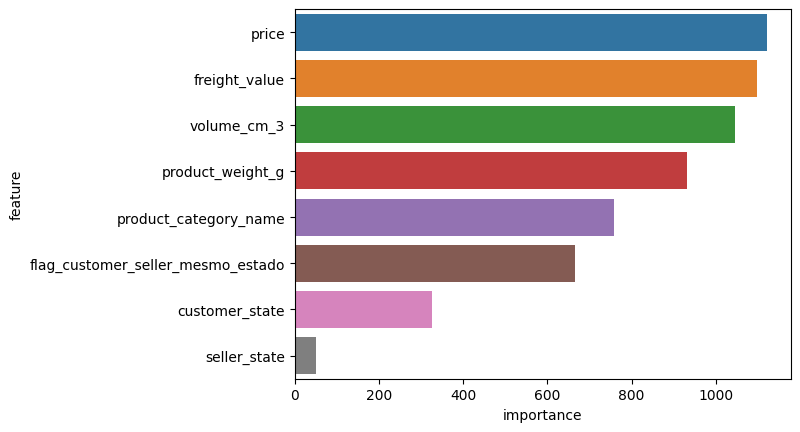

In [26]:
sns.barplot(df_feat_importance.sort_values("importance", ascending=False), y="feature", x="importance");

Vemos que a features "seller_state" e "customer_state" possuem importancia bem baixa para o modelo. Pensando em um modelo menos complexo e com menos dimensões, vamos retirar estas features e checar o efeito no desempenho do modelo:

In [29]:
# define features a serem utilizadas nos modelos
features_diag = [
    "price", "freight_value", "product_weight_g", "volume_cm_3", "flag_customer_seller_mesmo_estado",
    "product_category_name"
]

column_transformers_diag = ColumnTransformer(
    transformers=[
        ("robust_scaler", RobustScaler(), ["price", "freight_value"]),
        ("min_max_scaler", MinMaxScaler(), ["product_weight_g", "volume_cm_3"]),
        (
            "ordinal_encoder", 
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), 
            ["product_category_name"]
        )
    ],
    remainder="passthrough"
)

pipe_lgbm_diag = Pipeline(
    steps=[
        ("preprocess", column_transformers_diag),
        ("regressor", LGBMRegressor(objective="regression"))
    ]
)
grid_param_lgbm_diag = [
    {
        "regressor": [LGBMRegressor(objective="regression")],
        "regressor__n_estimators": [125, 150, 175, 200],
        "regressor__max_depth": [6, 7, 8, -1]
    }
]
grid_search_cv_lgbm_diag = GridSearchCV(
    pipe_lgbm_diag, grid_param_lgbm_diag, cv=5, verbose=3, scoring="neg_root_mean_squared_error", 
    n_jobs=1)
modelo_lgbm_melhor_hyperparam_diag = grid_search_cv_lgbm_diag.fit(X_train[features_diag], y_train)

print(
    f"\nRMSE medio encontrado: {abs(modelo_lgbm_melhor_hyperparam_diag.best_score_)}\n"
    f"Hyperparametros utilizados: {modelo_lgbm_melhor_hyperparam_diag.best_params_}"
)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[CV 1/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=6, regressor__n_estimators=125;, score=-8.357 total time=   2.8s
[CV 2/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=6, regressor__n_estimators=125;, score=-8.340 total time=   6.1s
[CV 3/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=6, regressor__n_estimators=125;, score=-8.048 total time=   4.3s
[CV 4/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=6, regressor__n_estimators=125;, score=-8.696 total time=   5.5s
[CV 5/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=6, regressor__n_estimators=125;, score=-8.293 total time=   4.3s
[CV 1/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=6, regressor__n_estimators=150;, score=-8.342 total time=   7.1s
[CV 2/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=6, regressor__n_estimators=15

In [30]:
y_pred = modelo_lgbm_melhor_hyperparam_diag.predict(X_test)
print(f"RMSE para o modelo de diagnostico do LGBM no conjunto de testes = {sqrt(mean_squared_error(y_test, y_pred))}")

RMSE para o modelo de diagnostico do LGBM no conjunto de testes = 8.631714688233624


Podemos ver que sem as features excluídas, o desempenho do modelo caiu. Antes tínhamos um RMSE de 8.36 comparado a 8.63 agora. Sendo assim, olhando apenas para desempenho, vemos que não faz sentido fazer a remoção das mesmas. Porém, em ambientes produtivos, o ganho de eficiência no treino e redução de dimensionalidade pode justificar a remoção, dado que a queda no desempenho não foi tão expressiva.

Vamos analisar os casos preditos na base de teste com maiores erros:

In [49]:
y_pred = loaded_pipe_lgbm.predict(X_test[features])
X_test["y_real"] = y_test
X_test["y_pred"] = y_pred
X_test["erro_absoluto"] = abs(y_test - y_pred)

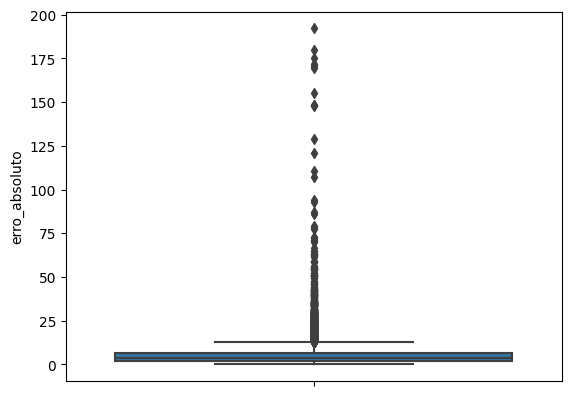

In [44]:
sns.boxplot(X_test, y="erro_absoluto");

Podemos ver que a maior concentração dos erros fica abaixo de 25 dias, tendo alguns casos de erro muito grandes, acima de 100 dias. Vamos checar esses casos:

In [45]:
X_test[X_test["erro_absoluto"] > 100]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type_1,payment_type_2,payment_value_1,payment_value_2,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,review_id,review_score,review_creation_date,review_answer_timestamp,total_order_value,tempo_aprovacao_dias,tempo_diff_previsto_entrega_dias,volume_cm_3,flag_customer_seller_mesmo_estado,y_real,y_pred,erro_absoluto
77830,c27815f7e3dd0b926b58552628481575,f85e9ec0719b16dc4dd0edd438793553,delivered,2017-03-15,2017-03-15,2017-03-21,2017-09-19,2017-04-10,credit_card,NaN,535.90,NaN,1,05e8eca656b87428a0e8453a2f335cdf,054694fa03fe82cec4b7551487331d74,2017-03-26,487.00,48.90,eletrodomesticos_2,45.0,442.0,6.0,9250.0,30.0,60.0,45.0,e7834c7e017fb854ac65189a66c33132,38170,perdizes,MG,15840,itajobi,SP,995b723688e96fcebb33288a918efc64,3.0,2017-04-05,2017-04-06,535.90,0.0,-162.0,81000.0,0,188.0,12.616669,175.383331
64082,450cb96c63e1e5b49d34f223f67976d2,27ae7c8a8fc20ce80d96f01b6f19961b,delivered,2018-05-21,2018-05-21,2018-06-01,2018-10-11,2018-06-27,credit_card,NaN,201.96,NaN,1,08d207a2357381d924df9b7cffbf2d22,93dc87703c046b603023e75222018b45,2018-06-06,179.00,22.96,relogios_presentes,59.0,1057.0,1.0,300.0,28.0,10.0,18.0,232422c2db1f7c69daf3b0f0421ebb43,29278,arace,ES,30315,belo horizonte,MG,37356da9f1563c39931932cb738e61b5,5.0,2018-06-30,2018-06-30,201.96,0.0,-106.0,5040.0,0,143.0,14.297008,128.702992
83863,6e82dcfb5eada6283dba34f164e636f5,59b42de1617fdda0b327375d35efd708,delivered,2017-05-17,2017-05-18,2017-05-19,2017-11-16,2017-06-14,credit_card,NaN,385.80,NaN,1,3ce943997ff85cad84ec6770b35d6bcd,9c0e69c7bf2619675bbadf47b43f655a,2017-05-25,175.91,11.40,informatica_acessorios,58.0,636.0,1.0,800.0,32.0,11.0,13.0,cf004a37244a84e6569ae75d1efa7149,97010,santa maria,RS,12230,sao jose dos campos,SP,2189b791046c691273250dc89b79bb77,5.0,2017-06-18,2017-06-22,385.80,1.0,-155.0,4576.0,0,183.0,13.600024,169.399976
36384,773f048245dc975a5f7c67c2415c88a0,1ad8bdb3f2f3403ef79ad8d80dc8d425,delivered,2018-01-24,2018-01-25,2018-01-26,2018-05-30,2018-02-23,credit_card,NaN,2092.86,NaN,1,23e44bcf966914b366c7e28f13327dfe,eeb6de78f79159600292e314a77cbd18,2018-01-31,2029.00,63.86,ferramentas_jardim,46.0,1075.0,1.0,4600.0,16.0,25.0,11.0,59bfe97acaf7979ebbc663af8bb1827d,48906,juazeiro,BA,88501,lages,SC,b2b6bc222acb64c3a561c96aa7838330,1.0,2018-02-28,2018-02-28,2092.86,1.0,-96.0,4400.0,0,126.0,18.931033,107.068967
42981,df6d8b7768a047c2981bae0a24afbb01,2da8c3c9c24c362231c8724105c23404,delivered,2017-04-04,2017-04-04 00:00:00.000000000,2017-04-05,2017-09-19,2017-05-10,credit_card,NaN,243.98,NaN,1,1ac8f5283525f67f04345f07c167ba80,3340ef1913fb70d28420f6ceb685c339,2017-04-10,210.90,33.08,informatica_acessorios,45.0,165.0,1.0,850.0,36.0,21.0,21.0,83a187df538ac982896968512093a175,60125,fortaleza,CE,87040,maringa,PR,a8058eabf445fdfff341f1e68a301949,1.0,2017-05-12,2017-05-12,243.98,0.0,-132.0,15876.0,0,168.0,19.549251,148.450749
62918,1b3190b2dfa9d789e1f14c05b647a14a,d306426abe5fca15e54b645e4462dc7b,delivered,2018-02-23,2018-02-23,2018-02-26,2018-09-19,2018-03-15,credit_card,NaN,162.25,NaN,1,ee406bf28024d97771c4b1e8b7e8e219,7a67c85e85bb2ce8582c35f2203ad736,2018-03-01,144.99,17.26,cool_stuff,54.0,629.0,1.0,1050.0,36.0,24.0,22.0,eb21169c3153a2b507fc7e76d561ff14,22723,rio de janeiro,RJ,3426,sao paulo,SP,ae83a790a3f01e1c43dd4d2863cebe0c,2.0,2018-03-17,2018-03-17,162.25,0.0,-188.0,19008.0,0,208.0,15.765493,192.234507
73211,28f12a3e5117f5e70bbdb45be9188639,71ae2df0198f8dab9a73978e46b63c6f,delivered,2017-05-03,2017-05-03,2017-05-04,2017-09-19,2017-06-07,credit_card,NaN,187.91,NaN,1,33202a8e7a645388c41ed714203d713

Vemos que todos os casos são de entregas que levaram muito tempo a serem entregues, passando de 100 dias. Esse valor de tempo de entrega "real" provavelmente está errado e não está mostrando o tempo real de entrega, mas isso precisaria ser validado com o negócio.

Por fim, buscando uma melhora nos resultados do modelo, vamos realizar uma busca por hiper-parâmetros com mais valores possíveis, tentando encontrar uma combinação que gere um melhor desempenho. Pelo aumento no número de valores possíveis dos hiper-parâmetros, ao invés de realizarmos um grid search, vamos realizar um randomized search:

In [47]:
with mlflow.start_run(run_name="lightgbm_cv_hyperparam"):
    pipe_lgbm_hyper = Pipeline(
        steps=[
            ("preprocess", column_transformers),
            ("regressor", LGBMRegressor(objective="regression"))
        ]
    )
    grid_param_lgbm_hyper = [
        {
            "regressor": [LGBMRegressor(objective="regression")],
            "regressor__n_estimators": [125, 150, 175, 200, 250, 300, 350, 400],
            "regressor__max_depth": [5, 10, 15, 20, -1]
        }
    ]
    random_search_cv_lgbm = RandomizedSearchCV(
        pipe_lgbm_hyper, grid_param_lgbm_hyper, cv=5, verbose=3, 
        scoring="neg_root_mean_squared_error", n_iter=10, n_jobs=1)
    modelo_lgbm_melhor_hyperparam_hyper = random_search_cv_lgbm.fit(X_train[features], y_train)

    mlflow.sklearn.log_model(modelo_lgbm_melhor_hyperparam_hyper, "pipe_lgbm")
    mlflow.log_metric("rmse", abs(modelo_lgbm_melhor_hyperparam_hyper.best_score_))
    mlflow.log_params({
        "n_estimators": modelo_lgbm_melhor_hyperparam_hyper.best_params_["regressor__n_estimators"],
        "max_depth": modelo_lgbm_melhor_hyperparam_hyper.best_params_["regressor__max_depth"]
    })

    print(
        f"\nMelhor rmse medio encontrado: {abs(modelo_lgbm_melhor_hyperparam_hyper.best_score_)}\n"
        f"Hyperparametros utilizados: {modelo_lgbm_melhor_hyperparam_hyper.best_params_}"
    )

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=15, regressor__n_estimators=150;, score=-8.064 total time=  11.9s
[CV 2/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=15, regressor__n_estimators=150;, score=-8.050 total time=   8.0s
[CV 3/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=15, regressor__n_estimators=150;, score=-7.758 total time=   9.3s
[CV 4/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=15, regressor__n_estimators=150;, score=-8.438 total time=  11.9s
[CV 5/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=15, regressor__n_estimators=150;, score=-8.018 total time=   6.8s
[CV 1/5] END regressor=LGBMRegressor(objective='regression'), regressor__max_depth=5, regressor__n_estimators=125;, score=-8.120 total time=   4.9s
[CV 2/5] END regressor=LGBMRegressor(objective

/home/olini/pes_embraer_intro_cd/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/olini/pes_embraer_intro_cd/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [48]:
y_pred = modelo_lgbm_melhor_hyperparam_hyper.predict(X_test[features])
print(f"RMSE para o modelo de LightGBM com maior tunagem de hiper-parametros no conjunto de testes = {sqrt(mean_squared_error(y_test, y_pred))}")

RMSE para o modelo de LightGBM com maior tunagem de hiper-parametros no conjunto de testes = 8.315621160250812


Com a tunagem de hiper-parâmetros utilizando mais valores possíveis, vemos que obtivemos uma melhora pequena no desempenho da métrica RMSE sob o conjunto de testes. Antes obtivemos 8.36 e agora 8.31. Apesar de singelo, em um contexto real deveria ser analisado e quantificado quanto ao ganho para o negócio que traria.

Para possíveis próximos passos de melhoria do modelo, poderíamos tentar criar mais features para serem utilizados pelo modelo, buscando um melhor poder preditivo do mesmo